<a href="https://colab.research.google.com/github/madhavadama/computervision/blob/master/Training_Pascal_VOC_data_extraction_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train using PASCAL-VOC dataset - Object Localization

## Table of Contents

1. Exploring directories in dataset
2. Import packages
3. Image Augentation through batches
4. Custom Batch Generator
5. Model Building
6. Compile Model
7. Tensorboard visualization
8. Train a Model
9. Test the Model

## 1. Exploring directories in dataset  <a id='download'>

In [0]:
!wget -q https://www.dropbox.com/s/63j3myz3hobc8cu/PASCAL_VOC.zip

In [0]:
!wget -q http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget -q http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar

In [5]:
!unzip PASCAL_VOC.zip > /dev/null; echo " done."
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null; echo " done."
!tar -xvf VOCtest_06-Nov-2007.tar > /dev/null; echo " done."

 done.
 done.
 done.


In [0]:
mv -t /content/PASCAL_VOC /content/VOCdevkit

In [11]:
!ls -R | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//--/g' -e 's/^/   /' -e 's/-/|/'

   .
   |-PASCAL_VOC
   |---VOCdevkit
   |-----VOC2007
   |-------Annotations
   |-------ImageSets
   |---------Layout
   |---------Main
   |---------Segmentation
   |-------JPEGImages
   |-------SegmentationClass
   |-------SegmentationObject
   |-sample_data


In [8]:
# find directories in PASCAL_VOC

import pathlib

PATH = pathlib.Path('PASCAL_VOC')
list(PATH.iterdir())

[PosixPath('PASCAL_VOC/pascal_val2007.json'),
 PosixPath('PASCAL_VOC/pascal_val2012.json'),
 PosixPath('PASCAL_VOC/pascal_train2012.json'),
 PosixPath('PASCAL_VOC/pascal_train2007.json'),
 PosixPath('PASCAL_VOC/pascal_test2007.json')]

In [12]:
#Let's find out where the JPEG Imges are
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/Annotations'),
 PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/SegmentationObject')]

In [0]:
#Assign JPEG folder path to JPEGS
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [14]:
#Let's have a look at the images in the folder
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/007923.jpg'),
 PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/008953.jpg'),
 PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/003108.jpg'),
 PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/008772.jpg'),
 PosixPath('PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/003741.jpg')]

## Import packages

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import model_selection

import imgaug                                              # Import imgaug library
from imgaug import augmenters as iaa                       # Import augmenters

from matplotlib import pyplot as plt

%matplotlib inline

In [0]:
# Setting the seed

tf.reset_default_graph()
tf.set_random_seed(12)

In [0]:
# Set the target size of image to be 180

TARGET_SIZE = 180

## Image Augmentation through batches

In [0]:
# Set the parameters for the image augmentor
#Training Augmenter
seq_train = iaa.Sequential([iaa.Resize({"height": TARGET_SIZE, "width": TARGET_SIZE}),
                     iaa.Sometimes(0.5,[
    
    iaa.Flipud(0.2),
    
    iaa.Affine(
        
        scale=(0.7, 0.9), #Zoom-in and Zoom-out
        rotate=(-10,10)
    ) 
    ])])

#Test image augmenter
seq_val = iaa.Sequential([iaa.Resize({"height": TARGET_SIZE, "width": TARGET_SIZE})])

In [0]:
#Augment images and bounding boxes

def images_augmentor_batch(X_batches,coord_batches,val_generate):
  
  
  #Preparing the bounding box information for Augmentor
  bounding_box_on_images=[]
  
  for X_batch,coord_batch in zip(X_batches,coord_batches):
      
    bounding_box=[]
    bounding_box.append(imgaug.BoundingBox(x1=coord_batch[1],y1=coord_batch[0],x2=coord_batch[3],y2=coord_batch[2]))
    bounding_box_on_images.append(imgaug.BoundingBoxesOnImage(bounding_box, shape=X_batch.shape) )
  
  #Select Training or Test Augmentor
  if val_generate == False:
    seq_det = seq_train.to_deterministic()
  else:
    seq_det = seq_val.to_deterministic()  
 
  #Augment Images and Bounding boxes
  images_aug = seq_det.augment_images(X_batches)
    
  bbs_aug=seq_det.augment_bounding_boxes(bounding_box_on_images)
    
  return (images_aug, bbs_aug)

  """
  
  if val_generate==False:
    
    seq_train_det = seq_train.to_deterministic() 
  
    images_aug = seq_train_det.augment_images(X_batches)
    
    bbs_aug=seq_train_det.augment_bounding_boxes(bounding_box_on_images)
    
    return (images_aug, bbs_aug)
    
  if val_generate==True:
    
    seq_val_det = seq_val.to_deterministic()
  
    images_aug = seq_val_det.augment_images(X_batches)
  
    bbs_aug=seq_val_det.augment_bounding_boxes(bounding_box_on_images)
    
    return (images_aug, bbs_aug)
  """

## Custom Batch Generator

In [0]:
# Define custom batch generators inplace of Keras image data generator

def batch_generator(df,batch_size,val_generate):
  
  #Find number of batches
  n_batch = df.shape[0] / batch_size
  #Split batches
  X_batches = np.split(df.fn.values, n_batch)
  coord_batches = np.split(df.bb_coords.values, n_batch)
  y_batches = np.split(df.cat_id.values, n_batch)
  
  while True:
  
    for b in range(len(X_batches)):
      
      
      bbs_aug_batch_normal = []
      
      #Load batch of images and bounding boxes and convert them to numpy array
      x_batch = np.array(map(tf.keras.preprocessing.image.load_img, X_batches[b]))
      x_batch = [plt.imread(IMG_PATH/fp) for fp in X_batches[b]]
      coord_batch = np.array(coord_batches[b])
      
      #Call function for augmentation
      images_aug_batch,bbs_aug_batch = images_augmentor_batch(x_batch,coord_batch,val_generate)
      images_aug_batch = np.array(images_aug_batch)
      
      #Apply preprocess suitable for inception resnet v2
      images_aug_batch = tf.keras.applications.inception_resnet_v2.preprocess_input(images_aug_batch)
      
      #Rearrange bounding boxes in (y1,x1,y2,x2) format
      for bb_aug in bbs_aug_batch:
        bbs_aug_batch_normal.append([bb_aug.bounding_boxes[0].y1,bb_aug.bounding_boxes[0].x1,bb_aug.bounding_boxes[0].y2,bb_aug.bounding_boxes[0].x2])
      bbs_aug_batch_normal = np.array(bbs_aug_batch_normal)
      
      #Convert to categorical
      y_batch = tf.keras.utils.to_categorical(y_batches[b],num_classes=20)
      
      #return images, bounding boxes and categorical labels using yield      
      yield (images_aug_batch) , [bbs_aug_batch_normal,y_batch]

## Model Building

In [0]:
# clear the current tensorflow graph and create new one
tf.keras.backend.clear_session()

In [0]:
## function not reqd because this is meant for a jupyter notebok
def create_model(trainable=False):
    
    model = tf.keras.applications.InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(TARGET_SIZE,TARGET_SIZE,3))
    
    
    for layer in model.layers[:-5]:
        layer.trainable = trainable

    out = model.layers[-1].output 
    
    x = tf.keras.layers.Flatten()(out)
    x = tf.keras.layers.Dropout(0.4)(x)                
    x = tf.keras.layers.Dense(64, activation='relu')(x)  
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(4, activation='relu', name="coords")(x)
    
    y = tf.keras.layers.Flatten()(out)
    y = tf.keras.layers.Dense(128, activation='relu')(y)    
    y = tf.keras.layers.Dropout(0.4)(y)
    y = tf.keras.layers.Dense(20, name = "classes", activation='softmax')(y)
    
    
    final_model = tf.keras.Model(inputs = model.input,
                                 outputs = [x,y])
    

    
    return final_model

## Compile Model

In [23]:
# Freeze all trainable paarameters
model=create_model(trainable=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
219062272/219055592 [==============================] - 26s 0us/step


In [0]:
# Provide more weight to classification than coordinates
model.compile(loss={"coords":'mae',"classes":'categorical_crossentropy'}, 
              loss_weights={"coords":1, "classes":4}, 
              optimizer='adam', 
              metrics={"classes":'accuracy'})

In [25]:
#Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 89, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 89, 89, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

We will define two callbacks:
- checkpoint: to save the best weights when validation accuracy increases
- tensorboard visualization

In [0]:
# create model checkpoint
filepath="object.localization.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [0]:
"""
Tensorboard log
"""
log_dir = './tf-log/obj_loc_v2'
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

## 6. Tensorboard visualization

In [28]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
# start tensorboard on localhost 6006

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)

In [0]:
# start ngrok and asking ngrok to forward to port to 6006 where tensorboard is running 
get_ipython().system_raw('./ngrok http 6006 &')

In [31]:
# get url generated from ngrok

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://5e544e90.ngrok.io


In [0]:
#Read largest bounding box pickle file
df = pd.read_pickle('lrg.csv')
#Subtract 1 from category id to make it start from 0
df['cat_id']=df['cat_id']-1

In [0]:
#Train-Test split
fit_index, val_index = model_selection.train_test_split(df.index,test_size=0.25,random_state=2017)
batch_size=32

In [37]:
val_index

Int64Index([1739,  327, 1382, 2409,   20, 2261,  837, 1207,  129, 2381,
            ...
             912, 1221,  575,  256,  149,  243, 1009,   55,  867,  279],
           dtype='int64', length=626)

In [0]:
#Create train generator and validation generator
train_generator = batch_generator(df.iloc[fit_index],batch_size,val_generate=False)
validation_generator = batch_generator(df.iloc[val_index],batch_size,val_generate=True)

## Training a Model

In [39]:
fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(len(fit_index)) // batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps= int(len(val_index)) // batch_size,
        callbacks=[tb_cb,checkpoint]
        )

Epoch 1/20
19/58 [========>.....................] - ETA: 18s - loss: 69.1483 - coords_loss: 60.9166 - classes_loss: 2.0579 - classes_acc: 0.5016
Epoch 00001: val_loss improved from inf to 69.14835, saving model to object.localization.best.hdf5
58/58 [==============================] - 151s 3s/step - loss: 52.1666 - coords_loss: 41.4707 - classes_loss: 2.6733 - classes_acc: 0.2757 - val_loss: 69.1483 - val_coords_loss: 60.9166 - val_classes_loss: 2.0579 - val_classes_acc: 0.5016
Epoch 2/20
19/58 [========>.....................] - ETA: 11s - loss: 74.1856 - coords_loss: 66.9957 - classes_loss: 1.7975 - classes_acc: 0.5847
Epoch 00002: val_loss did not improve from 69.14835
58/58 [==============================] - 17s 299ms/step - loss: 40.0457 - coords_loss: 32.1388 - classes_loss: 1.9767 - classes_acc: 0.4187 - val_loss: 74.1856 - val_coords_loss: 66.9957 - val_classes_loss: 1.7975 - val_classes_acc: 0.5847
Epoch 3/20
19/58 [========>.....................] - ETA: 11s - loss: 85.7075 - co

## Predict bounding box and class on new images

In [0]:
#Function for drawing outline
from matplotlib import patheffects
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [0]:
import matplotlib
def draw_rect(ax, b):
    patch = ax.add_patch(matplotlib.patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [0]:
# Function for Displaying image 
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = matplotlib.pyplot.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax

In [0]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [0]:
import json

trn_j = json.load((PATH/'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])

In [0]:
#Function for prediction
def predict_image(model,image_file_name):
  
  classifier=model

  img = tf.keras.preprocessing.image.load_img(image_file_name,target_size=(TARGET_SIZE, TARGET_SIZE))
  img_arr = tf.keras.preprocessing.image.img_to_array(img)
  #Normalize input image as per pre-trained model i.e inceptionResNet_v2
  img_arr = tf.keras.applications.inception_resnet_v2.preprocess_input(img_arr)
  #Create a batch of size 1
  x=img_arr.reshape(1,TARGET_SIZE,TARGET_SIZE,3) 
  
  
  result = classifier.predict(x)
  b = bb_hw(result[0][0])
  ax=show_img(img)
  draw_rect(ax, b)
  draw_text(ax, b[:2], cats[np.argmax(result[0][1])+1], sz=16)
 
  return result
  

In [0]:
#Get new images
!wget -q https://sarahelliottphotography.co.uk/wp-content/uploads/2017/01/autumn-childrens-shoot.jpg
!wget -q https://ak8.picdn.net/shutterstock/videos/30988048/thumb/1.jpg
!wget -q https://larastock.com/samples/NDMwNjU1MjE5YjNhYTg=/MTM1NTIxOWIzYWE4/6034-happy-young-man-jumping-against-background-of-sky-and-trees.jpg
!wget -q https://images01.foap.com/images/de830e93-a522-41dc-9ff4-49bb98660672/black-motorbike-in-the-green-nature-background.jpg
!wget -q https://images-na.ssl-images-amazon.com/images/I/71PxS7WoODL._SX466_.jpg
!wget -q http://www.trainbodyandmind.com/wp-content/uploads/2011/03/bike-to-work-1.jpg

IndexError: ignored

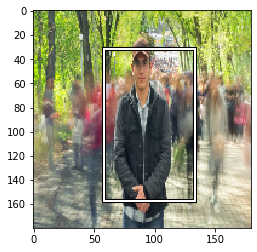

In [52]:
#Predict on new image
x=predict_image(model,'1.jpg')
x